### Libraries

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

### Data filtering to get jakarta data only

In [2]:
## Read in data
prov = gpd.read_file("../data/processed/low_res_sim.shp")  # Change path if needed
dist = gpd.read_file("../data/processed/high_res_sim.shp")

In [3]:
dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry
0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2.049701,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2.073381,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2.097063,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2.120744,0.123155,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1.369564,0.079001,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [4]:
# get the unique district names
unique_districts = dist["District"].unique()
print(unique_districts)
jkt = ['KOTA JAKARTA BARAT',
 'KOTA JAKARTA PUSAT', 'KOTA JAKARTA SELATAN', 'KOTA JAKARTA TIMUR',
 'KOTA JAKARTA UTARA']

['BANDUNG' 'BANDUNG BARAT' 'BEKASI' 'BOGOR' 'CIAMIS' 'CIANJUR' 'CIREBON'
 'GARUT' 'INDRAMAYU' 'KARAWANG' 'KOTA BANDUNG' 'KOTA BANJAR' 'KOTA BEKASI'
 'KOTA BOGOR' 'KOTA CIMAHI' 'KOTA CIREBON' 'KOTA DEPOK'
 'KOTA JAKARTA BARAT' 'KOTA JAKARTA PUSAT' 'KOTA JAKARTA SELATAN'
 'KOTA JAKARTA TIMUR' 'KOTA JAKARTA UTARA' 'KOTA SUKABUMI'
 'KOTA TASIKMALAYA' 'KUNINGAN' 'MAJALENGKA' 'PANGANDARAN' 'PURWAKARTA'
 'SUBANG' 'SUKABUMI' 'SUMEDANG' 'TASIKMALAYA']


In [5]:
#filter df_combined to only retain observations in district = jkt list
jkt_dist = dist[dist["District"].isin(jkt)]

#filter for jkt_prov data
jkt_prov = prov[prov["Province"] == "DKI Jakarta"]

In [6]:
#filter df_combined to only retain observations in district = west java list
java_dist = dist[~dist["District"].isin(jkt)]

#filter for jkt_prov data
java_prov = prov[prov["Province"] == "Jawa Barat"]

In [7]:
#print head
jkt_dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry
68,KOTA JAKARTA BARAT,2020,124.44,0.8138,DKI Jakarta,161,184826,1.485262,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
69,KOTA JAKARTA BARAT,2021,124.44,0.8176,DKI Jakarta,138,183270,1.472758,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
70,KOTA JAKARTA BARAT,2022,125.00,0.8251,DKI Jakarta,420,181715,1.453720,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
71,KOTA JAKARTA BARAT,2023,125.00,0.8302,DKI Jakarta,359,180159,1.441272,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
72,KOTA JAKARTA PUSAT,2020,52.38,0.8139,DKI Jakarta,127,73140,1.396334,0.993514,"POLYGON ((106.83247 -6.14138, 106.83282 -6.141..."


<Axes: >

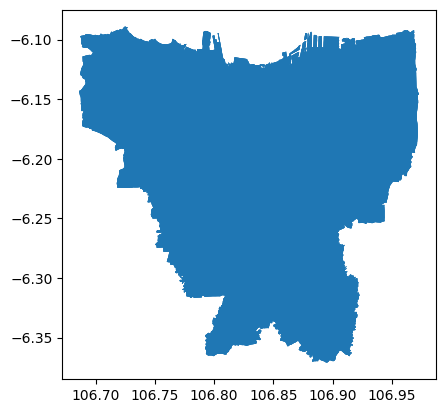

In [8]:
#try plotting the map alone
jkt_dist.plot()

In [9]:
jkt_prov.head()

,Province,Year,Cases,Population,HDI,Area_sq_km,Pop_den,urbanicity,geometry
0,DKI Jakarta,2020,1217,801232,0.82088,653.83,1.225444,0.931345,"MULTIPOLYGON (((106.84094 -6.34198, 106.8407 -..."
1,DKI Jakarta,2021,1048,796729,0.82340,653.83,1.218557,0.931345,"MULTIPOLYGON (((106.84094 -6.34198, 106.8407 -..."
2,DKI Jakarta,2022,2113,792228,0.82818,650.50,1.217875,0.931345,"MULTIPOLYGON (((106.84094 -6.34198, 106.8407 -..."
3,DKI Jakarta,2023,1562,787726,0.83372,650.25,1.211420,0.931345,"MULTIPOLYGON (((106.84094 -6.34198, 106.8407 -..."


In [10]:
# save as jkt combined divisions so next time dont need to filter again
jkt_dist.to_file("../data/processed/jkt_dist.shp")
jkt_prov.to_file("../data/processed/jkt_prov.shp")

java_dist.to_file("../data/processed/java_dist.shp")
java_prov.to_file("../data/processed/java_prov.shp")

## Plot data distribution of DKI Jakarta with and without Kepulauan Seribu

In [11]:
hi = gpd.read_file("../data/processed/high_res.shp")
lo = gpd.read_file("../data/processed/low_res.shp")

In [12]:
#filter to DKI Jakarta only
hi = hi[hi["Province"] == "DKI Jakarta"]
lo = lo[lo["Province"] == "DKI Jakarta"]

hi_small = hi[hi["District"] != "KEPULAUAN SERIBU"]
lo_small = gpd.read_file("../data/processed/low_res_sim.shp")

lo_small = lo_small[lo_small["Province"] == "DKI Jakarta"]

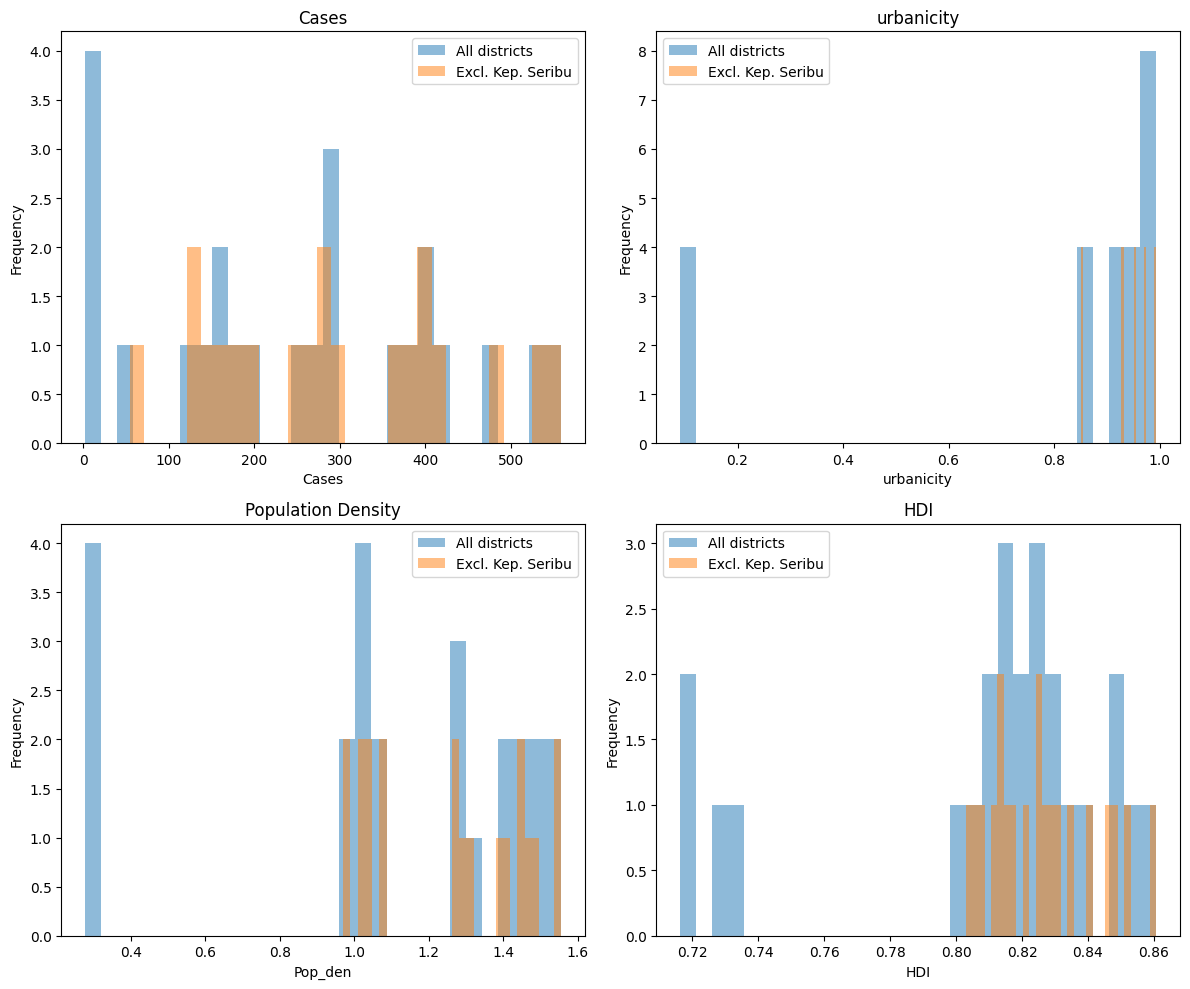

In [13]:
vars_to_plot = ["Cases", "urbanicity", "Pop_den", "HDI"]
titles      = ["Cases", "urbanicity", "Population Density", "HDI"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, var, title in zip(axes, vars_to_plot, titles):
    all_vals   = hi[var].dropna().values
    nodki_vals = hi_small[var].dropna().values

    ax.hist(all_vals,   bins=30, alpha=0.5, label="All districts")
    ax.hist(nodki_vals, bins=30, alpha=0.5, label="Excl. Kep. Seribu")
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()


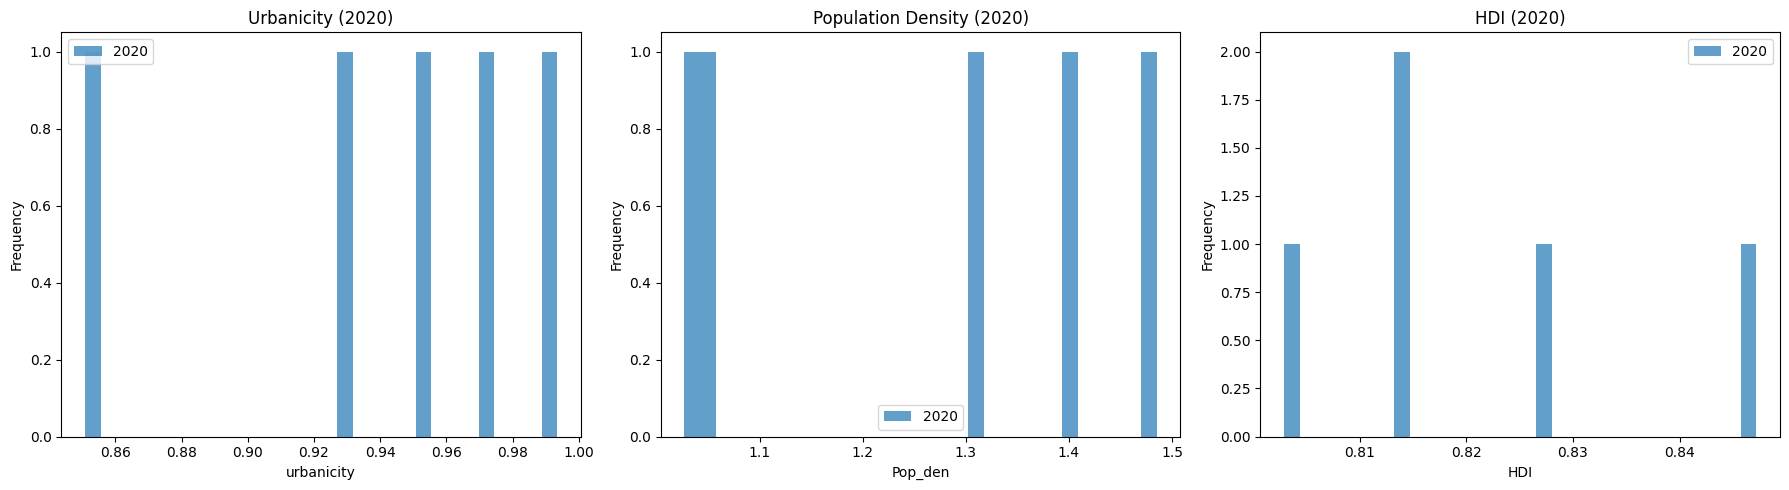

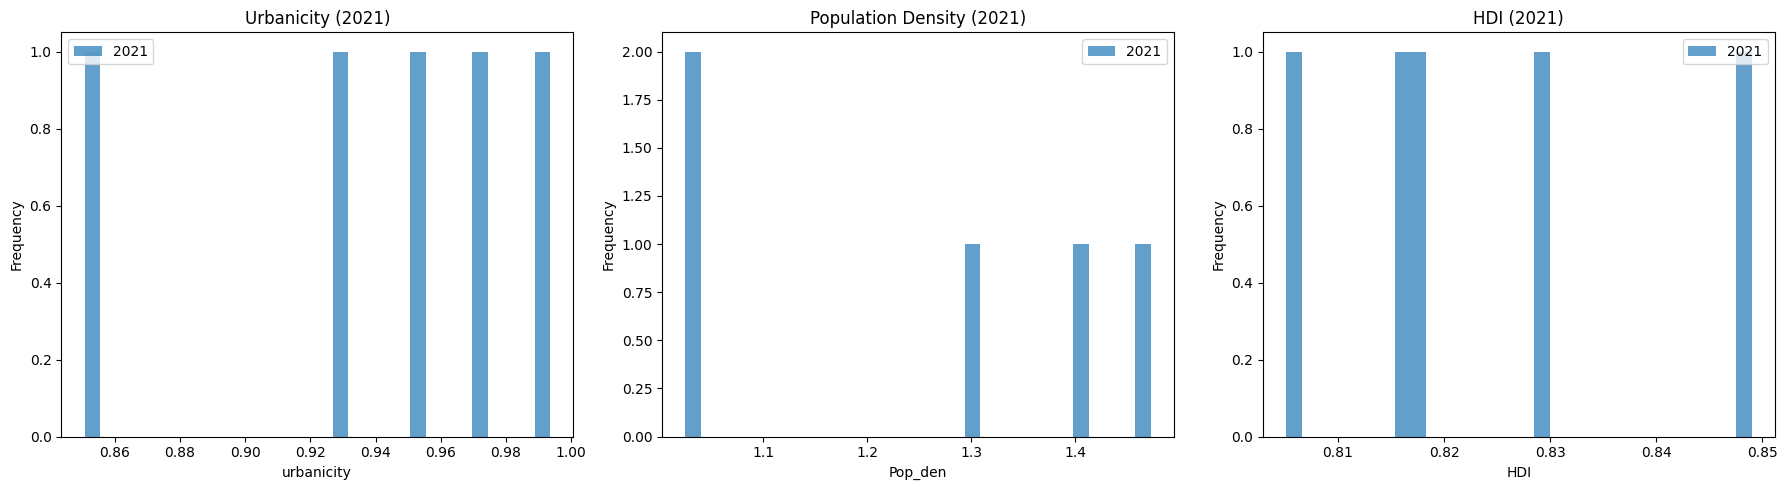

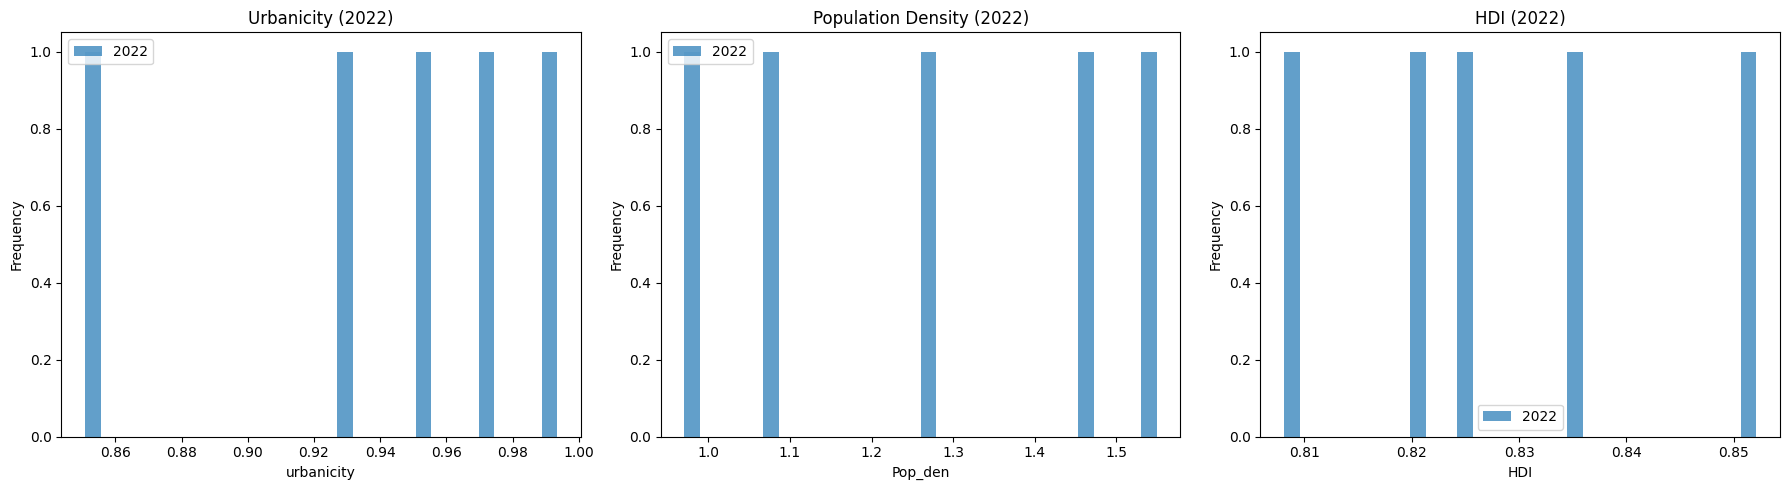

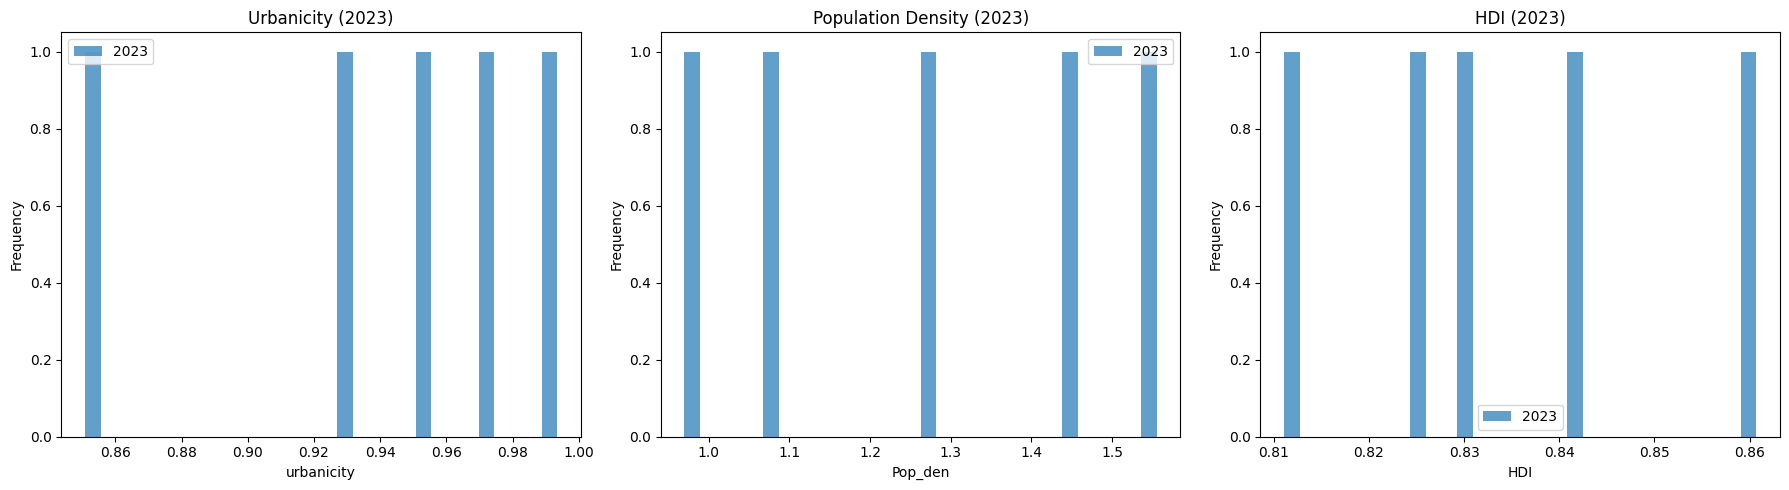

In [15]:
import matplotlib.pyplot as plt

# Updated variables and titles (excluding "Cases")
vars_to_plot = ["urbanicity", "Pop_den", "HDI"]
titles      = ["Urbanicity", "Population Density", "HDI"]

# Get list of years
years = hi_small['Year'].unique()
years.sort()

# Loop over each year
for year in years:
    # Subset data for the year
    hi_small_year = hi_small[hi_small['Year'] == year]

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes = axes.ravel()

    # Loop over each variable
    for ax, var, title in zip(axes, vars_to_plot, titles):
        vals = hi_small_year[var].dropna().values

        ax.hist(vals, bins=30, alpha=0.7, label=f"{year}")
        ax.set_title(f"{title} ({year})")
        ax.set_xlabel(var)
        ax.set_ylabel("Frequency")
        ax.legend()

    plt.tight_layout()
    plt.show()


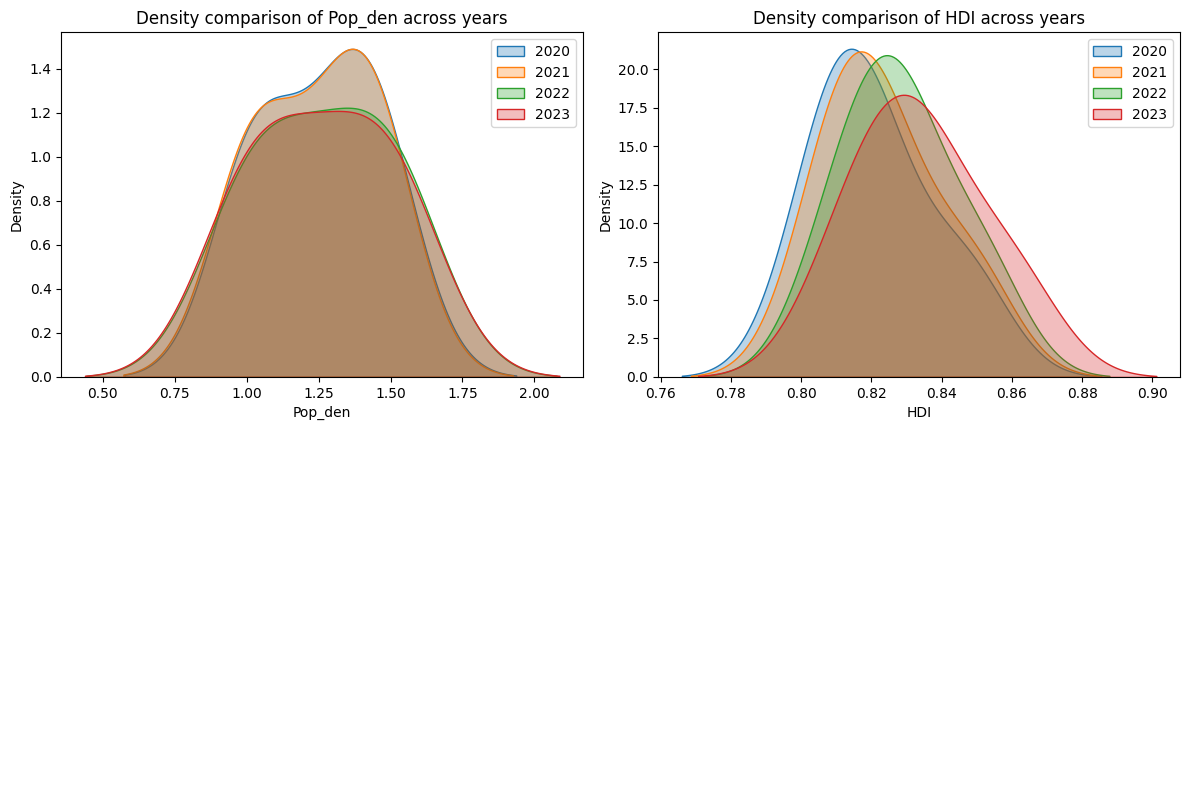

In [22]:
#plot kernel density (visual check)
vars_to_plot = ["Pop_den", "HDI"]

# Pick years you want to compare
years_to_compare = [2020, 2021, 2022, 2023]

# Plotting
plt.figure(figsize=(12, 8))

for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a subplot for each variable (2 rows, 2 columns)
    for year in years_to_compare:
        subset = hi_small[hi_small['Year'] == year]
        sns.kdeplot(subset[var].dropna(), label=f"{year}", fill=True, alpha=0.3)

    plt.title(f"Density comparison of {var} across years")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend()

# Hide the empty subplot (bottom right)
plt.subplot(2, 2, 4).axis('off')

plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [26]:
from scipy.stats import ks_2samp

# Variables to test
vars_to_test = ["Pop_den", "HDI"]

# List of all years to compare
years = [2020, 2021, 2022, 2023]

# Prepare list for results
ks_results = []

# Perform KS tests for each variable and each pair of years
for var in vars_to_test:
    print(f"\nTesting {var}:")
    
    for year1 in years:
        for year2 in years:
            if year1 < year2:  # Ensure we only compare each pair once
                # Subset data for each year
                data1 = hi_small[hi_small['Year'] == year1][var].dropna()
                data2 = hi_small[hi_small['Year'] == year2][var].dropna()
                
                # Perform the KS test
                stat, pvalue = ks_2samp(data1, data2)
                
                # Append results to the list
                ks_results.append([var, f"{year1} vs {year2}", stat, pvalue])

# Convert results into a DataFrame for better formatting
import pandas as pd

ks_df = pd.DataFrame(ks_results, columns=["Variable", "Year Comparison", "KS Statistic", "P-value"])

# Display the result in a table format
print(ks_df)



Testing Pop_den:

Testing HDI:
   Variable Year Comparison  KS Statistic   P-value
0   Pop_den    2020 vs 2021           0.2  1.000000
1   Pop_den    2020 vs 2022           0.2  1.000000
2   Pop_den    2020 vs 2023           0.2  1.000000
3   Pop_den    2021 vs 2022           0.2  1.000000
4   Pop_den    2021 vs 2023           0.2  1.000000
5   Pop_den    2022 vs 2023           0.2  1.000000
6       HDI    2020 vs 2021           0.4  0.873016
7       HDI    2020 vs 2022           0.4  0.873016
8       HDI    2020 vs 2023           0.4  0.873016
9       HDI    2021 vs 2022           0.4  0.873016
10      HDI    2021 vs 2023           0.4  0.873016
11      HDI    2022 vs 2023           0.4  0.873016


C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.p